In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer, TabTransformer
import sys
import time
from torch import Tensor
from typing import Literal

device_in_use='cuda'

c:\Users\smbm2\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\validation.csv') #READ FROM RIGHT SPOT

In [3]:
cont_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']
target = ['Cover_Type']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cont_columns, 'Cover_Type')
val_dataset = SingleTaskDataset(df_val, cont_columns, 'Cover_Type')
test_dataset = SingleTaskDataset(df_test, cont_columns, 'Cover_Type')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

[7]


In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class EmbeddingsRFFforIndividualFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont,  num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforIndividualFeatures, self).__init__()

        self.rff_on = rff_on

        self.linear_on = linear_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)

        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)


        return class_embeddings, context

class EmbeddingsRFFforAllFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforAllFeatures, self).__init__()

        self.rff_on = rff_on
        self.n_cont = n_cont
        self.linear_on=linear_on

        if self.rff_on:
            self.rff = GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) 
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i in range(self.n_cont):
                input = x[:,i,:]
                out = self.rff(input)
                rff_vectors.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context
    
class PeriodicActivation(nn.Module):
    def __init__(self, sigma, embed_size, n_cont, num_target_labels,trainable: bool, initialization: str, linear_on:bool):
        super(PeriodicActivation, self).__init__()

        self.n = embed_size
        self.sigma = sigma
        self.trainable = trainable
        self.initialization = initialization
        self.linear_on = linear_on
        self.n_cont = n_cont

        if self.initialization == 'log-linear':
            coefficients = self.sigma ** (torch.arange(self.n//2) / self.n)
            coefficients = coefficients[None]
        else:
            assert self.initialization == 'normal'
            coefficients = torch.normal(0.0, self.sigma, (1, self.n//2))

        if self.trainable:
            self.coefficients = nn.Parameter(coefficients)
        else:
            self.register_buffer('coefficients', coefficients)

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=embed_size, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)

        temp = []
        for i in range(self.n_cont):
            input = x[:,i,:]
            out = torch.cat([torch.cos(self.coefficients * input), torch.sin(self.coefficients * input)], dim=-1)
            temp.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(temp, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = temp

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context


class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 rff_on = True,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 n_cont = 0,
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8],
                embedding_scheme ="rff_unique",
                trainable=True,
                linear_on=True
                 ):
        super(CATTransformer, self).__init__()

        assert(embedding_scheme in ['rff_unique', 'rff', 'log-linear_periodic', 'normal_periodic']), "wrong embedding_scheme"

        if embedding_scheme == 'rff_unique':
            self.embeddings = EmbeddingsRFFforIndividualFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes), linear_on=linear_on)
        elif embedding_scheme == 'log-linear_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, input_size=input_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='log-linear', linear_on=linear_on)
        elif embedding_scheme == 'normal_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, input_size=input_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='normal',linear_on=linear_on)
        else:
            self.embeddings = EmbeddingsRFFforAllFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes),linear_on=linear_on)
            
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw
    
    # Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (features,labels_task1) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
      features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

      #compute prediction error
      task_predictions = model(features) #contains a list of the tensor outputs for each task

      loss = loss_function(task_predictions, labels_task1)
      total_loss += loss.item()

      #computing accuracy for first target
      y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
      _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
      total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
      total_samples_1 += labels_task1.size(0)
      all_targets_1.extend(labels_task1.cpu().numpy())
      all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

# RFF to each feature - Linear

In [7]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

Epoch [ 1/100]       | Train: Loss 0.74157, Accuracy 0.68607                             | Test: Loss 0.64749, Accuracy 0.72821, F1 0.71338


KeyboardInterrupt: 

# RFF to each feature. No Linear

Epoch [ 1/100]       | Train: Loss 0.46277, Accuracy 0.78212                             | Test: Loss 0.40195, Accuracy 0.82404, F1 0.80994
Epoch [ 2/100]       | Train: Loss 0.37366, Accuracy 0.82696                             | Test: Loss 0.36487, Accuracy 0.83610, F1 0.82448
Epoch [ 3/100]       | Train: Loss 0.34966, Accuracy 0.83843                             | Test: Loss 0.35154, Accuracy 0.83792, F1 0.83620
Epoch [ 4/100]       | Train: Loss 0.33873, Accuracy 0.84390                             | Test: Loss 0.34317, Accuracy 0.84338, F1 0.83245
Epoch [ 5/100]       | Train: Loss 0.33418, Accuracy 0.84524                             | Test: Loss 0.34553, Accuracy 0.84213, F1 0.82647
Epoch [ 6/100]       | Train: Loss 0.32991, Accuracy 0.84761                             | Test: Loss 0.33390, Accuracy 0.84679, F1 0.84100
Epoch [ 7/100]       | Train: Loss 0.32573, Accuracy 0.84972                             | Test: Loss 0.34083, Accuracy 0.83940, F1 0.84070
Epoch [ 8/100]      

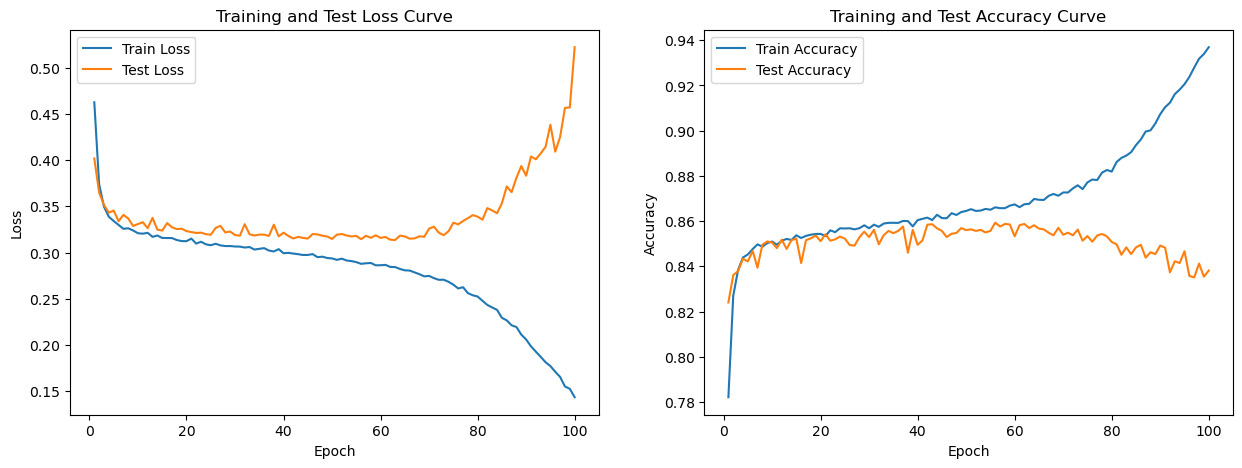

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# RFF - Linear

Epoch [ 1/100]       | Train: Loss 0.43120, Accuracy 0.79847                             | Test: Loss 0.36735, Accuracy 0.83485, F1 0.81653
Epoch [ 2/100]       | Train: Loss 0.33748, Accuracy 0.84287                             | Test: Loss 0.34032, Accuracy 0.84133, F1 0.84185
Epoch [ 3/100]       | Train: Loss 0.32205, Accuracy 0.85019                             | Test: Loss 0.32418, Accuracy 0.85305, F1 0.84269
Epoch [ 4/100]       | Train: Loss 0.31171, Accuracy 0.85466                             | Test: Loss 0.31836, Accuracy 0.85453, F1 0.84460
Epoch [ 5/100]       | Train: Loss 0.30446, Accuracy 0.85899                             | Test: Loss 0.31759, Accuracy 0.85748, F1 0.85546
Epoch [ 6/100]       | Train: Loss 0.30468, Accuracy 0.85721                             | Test: Loss 0.31105, Accuracy 0.85794, F1 0.84973
Epoch [ 7/100]       | Train: Loss 0.29902, Accuracy 0.86089                             | Test: Loss 0.30785, Accuracy 0.85976, F1 0.85274
Epoch [ 8/100]      

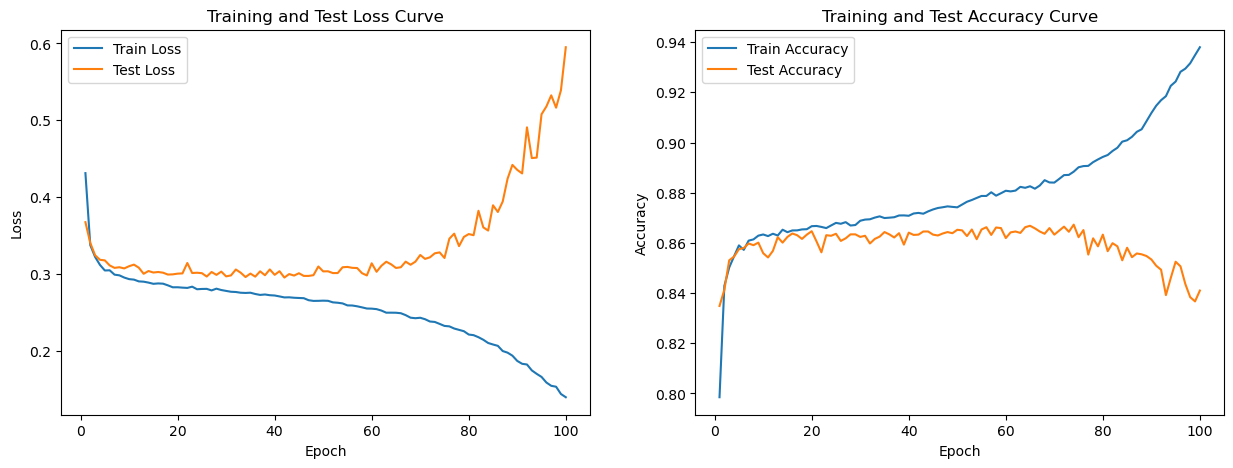

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# RFF. No Linear

Epoch [ 1/100]       | Train: Loss 0.44636, Accuracy 0.78900                             | Test: Loss 0.42898, Accuracy 0.81153, F1 0.77416
Epoch [ 2/100]       | Train: Loss 0.36860, Accuracy 0.82743                             | Test: Loss 0.39029, Accuracy 0.82575, F1 0.80340
Epoch [ 3/100]       | Train: Loss 0.35541, Accuracy 0.83533                             | Test: Loss 0.36035, Accuracy 0.83519, F1 0.83196
Epoch [ 4/100]       | Train: Loss 0.34533, Accuracy 0.84153                             | Test: Loss 0.35245, Accuracy 0.84122, F1 0.83537
Epoch [ 5/100]       | Train: Loss 0.34344, Accuracy 0.84325                             | Test: Loss 0.35073, Accuracy 0.84224, F1 0.83356
Epoch [ 6/100]       | Train: Loss 0.34282, Accuracy 0.83936                             | Test: Loss 0.34910, Accuracy 0.83974, F1 0.82851
Epoch [ 7/100]       | Train: Loss 0.33832, Accuracy 0.84311                             | Test: Loss 0.34773, Accuracy 0.84020, F1 0.83366
Epoch [ 8/100]      

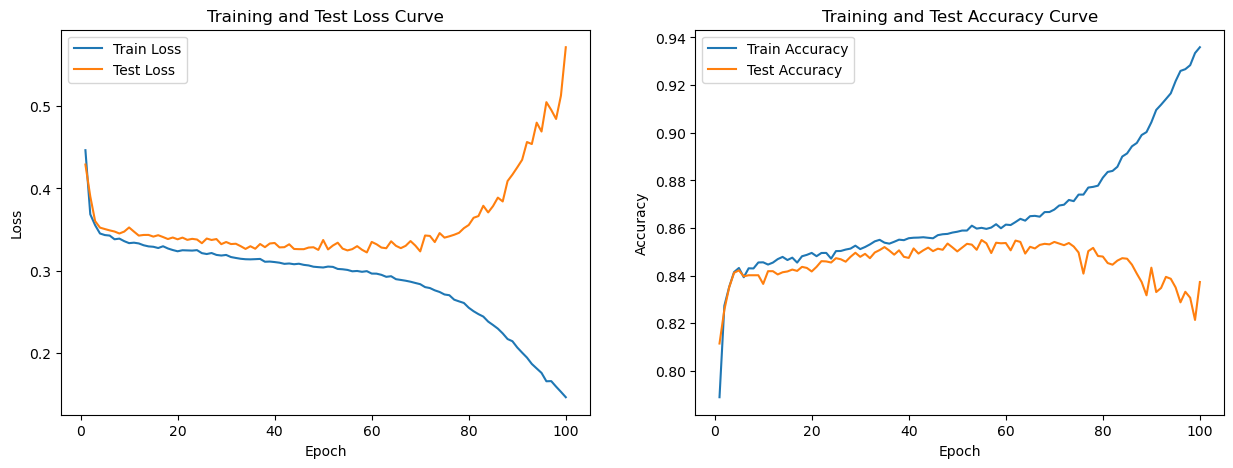

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff',
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Normal Periodic Embedding. No Linear layers

Epoch [ 1/100]       | Train: Loss 0.43752, Accuracy 0.79584                             | Test: Loss 0.38052, Accuracy 0.81915, F1 0.81933
Epoch [ 2/100]       | Train: Loss 0.36183, Accuracy 0.83094                             | Test: Loss 0.38148, Accuracy 0.82962, F1 0.81066
Epoch [ 3/100]       | Train: Loss 0.35245, Accuracy 0.83547                             | Test: Loss 0.35825, Accuracy 0.83360, F1 0.82669
Epoch [ 4/100]       | Train: Loss 0.34709, Accuracy 0.83872                             | Test: Loss 0.35408, Accuracy 0.83530, F1 0.82056
Epoch [ 5/100]       | Train: Loss 0.34319, Accuracy 0.84080                             | Test: Loss 0.35384, Accuracy 0.83690, F1 0.82439
Epoch [ 6/100]       | Train: Loss 0.34072, Accuracy 0.84112                             | Test: Loss 0.34876, Accuracy 0.83644, F1 0.82693
Epoch [ 7/100]       | Train: Loss 0.33999, Accuracy 0.84238                             | Test: Loss 0.35249, Accuracy 0.83997, F1 0.82976
Epoch [ 8/100]      

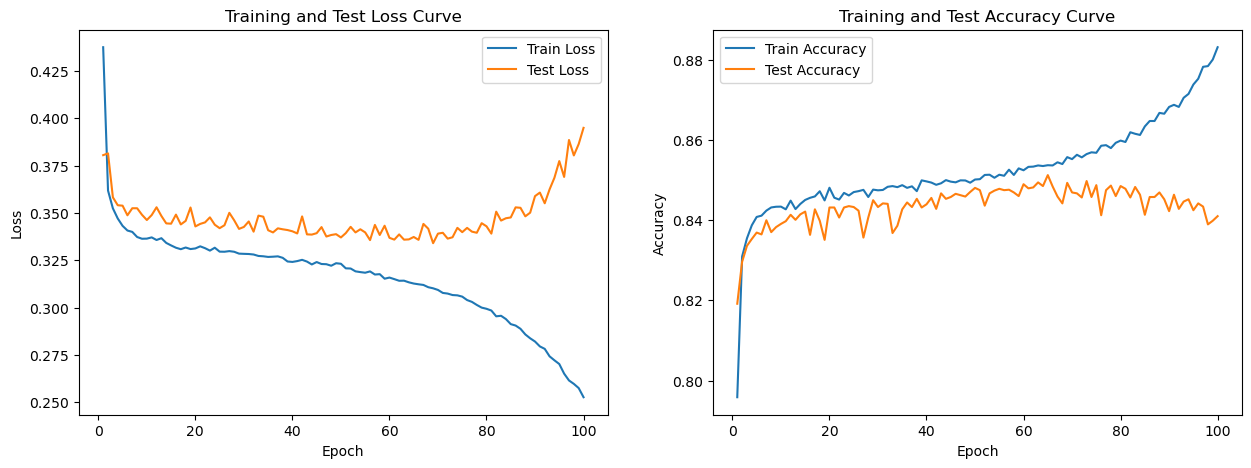

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                      
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                      
                       embedding_scheme='normal_periodic',
                       trainable=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Normal Periodic Embedding - Linear

Epoch [ 1/100]       | Train: Loss 0.41172, Accuracy 0.81052                             | Test: Loss 0.33365, Accuracy 0.84566, F1 0.84049
Epoch [ 2/100]       | Train: Loss 0.32465, Accuracy 0.84782                             | Test: Loss 0.32760, Accuracy 0.84691, F1 0.82921
Epoch [ 3/100]       | Train: Loss 0.31410, Accuracy 0.85305                             | Test: Loss 0.31731, Accuracy 0.85373, F1 0.84046
Epoch [ 4/100]       | Train: Loss 0.30770, Accuracy 0.85647                             | Test: Loss 0.31648, Accuracy 0.85703, F1 0.85431
Epoch [ 5/100]       | Train: Loss 0.30632, Accuracy 0.85697                             | Test: Loss 0.31131, Accuracy 0.85805, F1 0.85143
Epoch [ 6/100]       | Train: Loss 0.30396, Accuracy 0.85849                             | Test: Loss 0.31763, Accuracy 0.85248, F1 0.83850
Epoch [ 7/100]       | Train: Loss 0.30192, Accuracy 0.85864                             | Test: Loss 0.32200, Accuracy 0.85612, F1 0.84438
Epoch [ 8/100]      

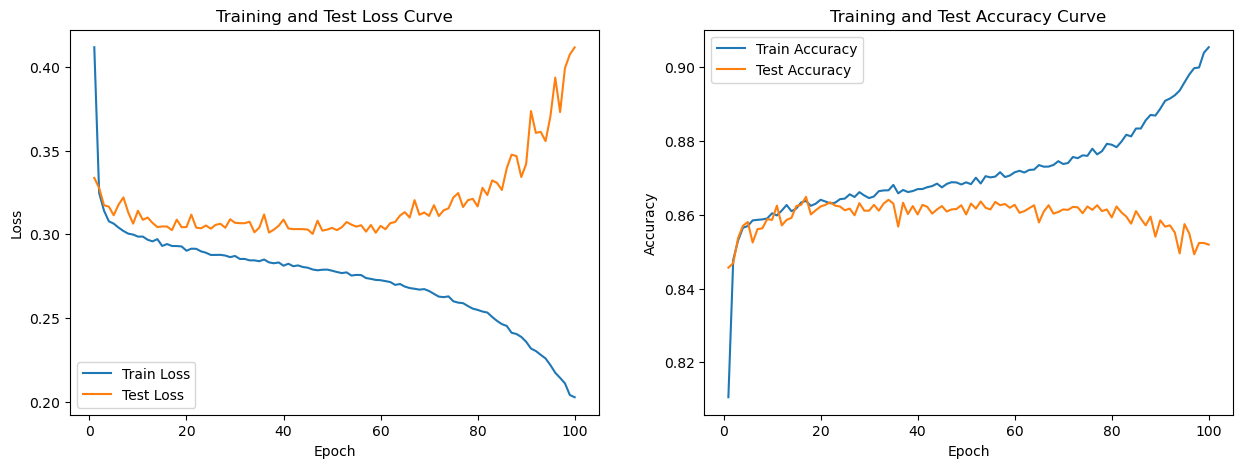

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                    
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                     
                       embedding_scheme='normal_periodic',
                       trainable=True,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Normal - no Linear

Epoch [ 1/100]       | Train: Loss 0.43853, Accuracy 0.79610                             | Test: Loss 0.40136, Accuracy 0.81961, F1 0.79281
Epoch [ 2/100]       | Train: Loss 0.36091, Accuracy 0.83059                             | Test: Loss 0.36619, Accuracy 0.82894, F1 0.82699
Epoch [ 3/100]       | Train: Loss 0.35055, Accuracy 0.83626                             | Test: Loss 0.37775, Accuracy 0.82780, F1 0.80528
Epoch [ 4/100]       | Train: Loss 0.34860, Accuracy 0.83618                             | Test: Loss 0.35160, Accuracy 0.83326, F1 0.82513
Epoch [ 5/100]       | Train: Loss 0.34598, Accuracy 0.83822                             | Test: Loss 0.35654, Accuracy 0.83451, F1 0.82767
Epoch [ 6/100]       | Train: Loss 0.34115, Accuracy 0.84074                             | Test: Loss 0.35082, Accuracy 0.83667, F1 0.83129
Epoch [ 7/100]       | Train: Loss 0.33963, Accuracy 0.84100                             | Test: Loss 0.35415, Accuracy 0.83838, F1 0.83119
Epoch [ 8/100]      

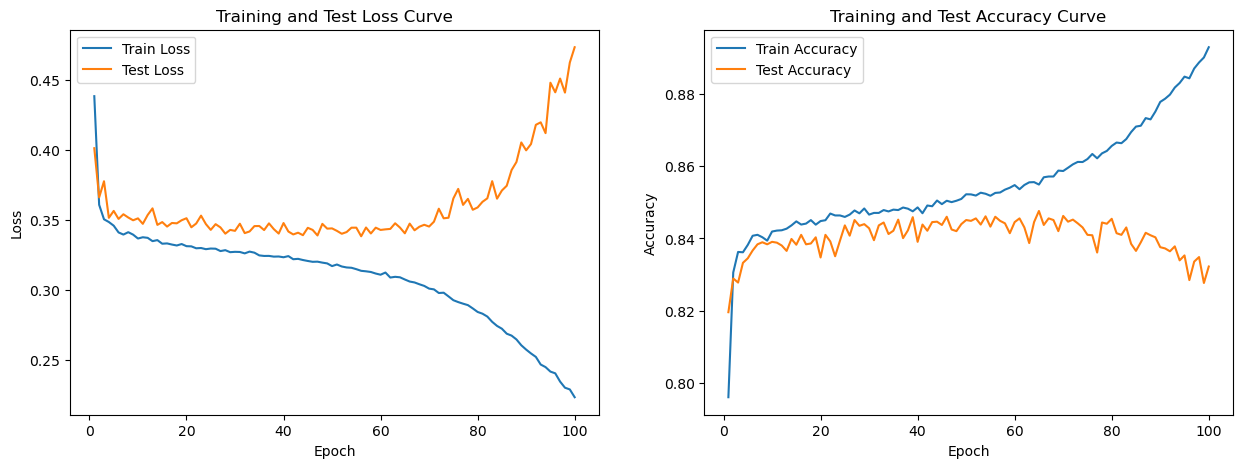

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                    
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                    
                       embedding_scheme='normal_periodic',
                       trainable=False,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Normal - Linear

Epoch [ 1/100]       | Train: Loss 0.42148, Accuracy 0.80640                             | Test: Loss 0.33136, Accuracy 0.84941, F1 0.84337
Epoch [ 2/100]       | Train: Loss 0.32289, Accuracy 0.84855                             | Test: Loss 0.32593, Accuracy 0.85146, F1 0.85011
Epoch [ 3/100]       | Train: Loss 0.31250, Accuracy 0.85601                             | Test: Loss 0.31614, Accuracy 0.85384, F1 0.84364
Epoch [ 4/100]       | Train: Loss 0.30465, Accuracy 0.85712                             | Test: Loss 0.31359, Accuracy 0.85737, F1 0.85317
Epoch [ 5/100]       | Train: Loss 0.30385, Accuracy 0.85805                             | Test: Loss 0.32460, Accuracy 0.84816, F1 0.83109
Epoch [ 6/100]       | Train: Loss 0.30261, Accuracy 0.85922                             | Test: Loss 0.30888, Accuracy 0.85919, F1 0.85329
Epoch [ 7/100]       | Train: Loss 0.29964, Accuracy 0.86086                             | Test: Loss 0.31218, Accuracy 0.85726, F1 0.84714
Epoch [ 8/100]      

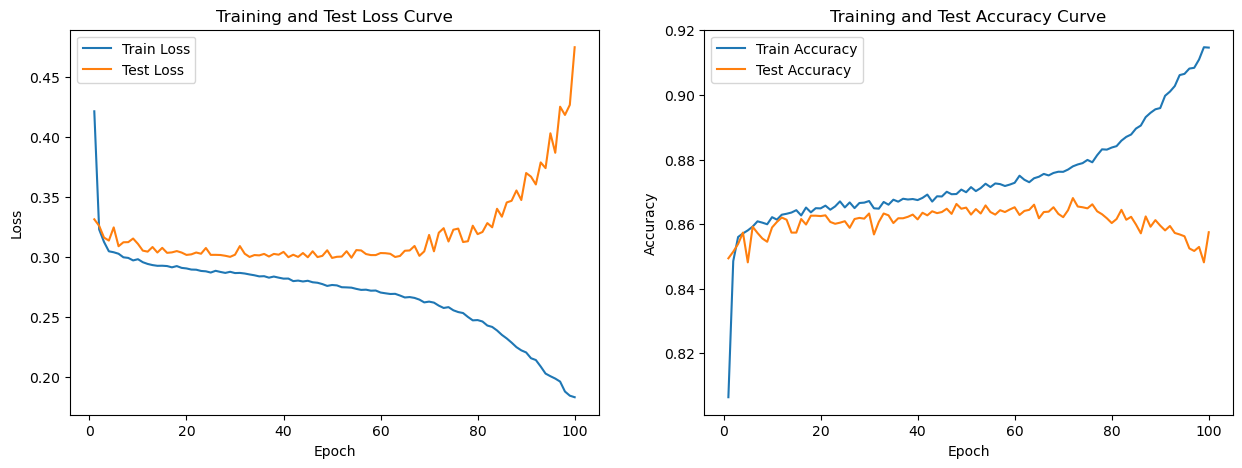

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
               
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                      
                       embedding_scheme='normal_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Log-Linear Periodic. No Linear

Epoch [ 1/100]       | Train: Loss 0.43557, Accuracy 0.79569                             | Test: Loss 0.38258, Accuracy 0.82416, F1 0.80959
Epoch [ 2/100]       | Train: Loss 0.36547, Accuracy 0.82898                             | Test: Loss 0.36730, Accuracy 0.82985, F1 0.82583
Epoch [ 3/100]       | Train: Loss 0.35748, Accuracy 0.83278                             | Test: Loss 0.36194, Accuracy 0.83167, F1 0.82112
Epoch [ 4/100]       | Train: Loss 0.35258, Accuracy 0.83588                             | Test: Loss 0.35981, Accuracy 0.83439, F1 0.82939
Epoch [ 5/100]       | Train: Loss 0.34765, Accuracy 0.83749                             | Test: Loss 0.35471, Accuracy 0.83269, F1 0.81719
Epoch [ 6/100]       | Train: Loss 0.34644, Accuracy 0.83872                             | Test: Loss 0.35630, Accuracy 0.83587, F1 0.82244
Epoch [ 7/100]       | Train: Loss 0.34246, Accuracy 0.84091                             | Test: Loss 0.35870, Accuracy 0.83963, F1 0.83291
Epoch [ 8/100]      

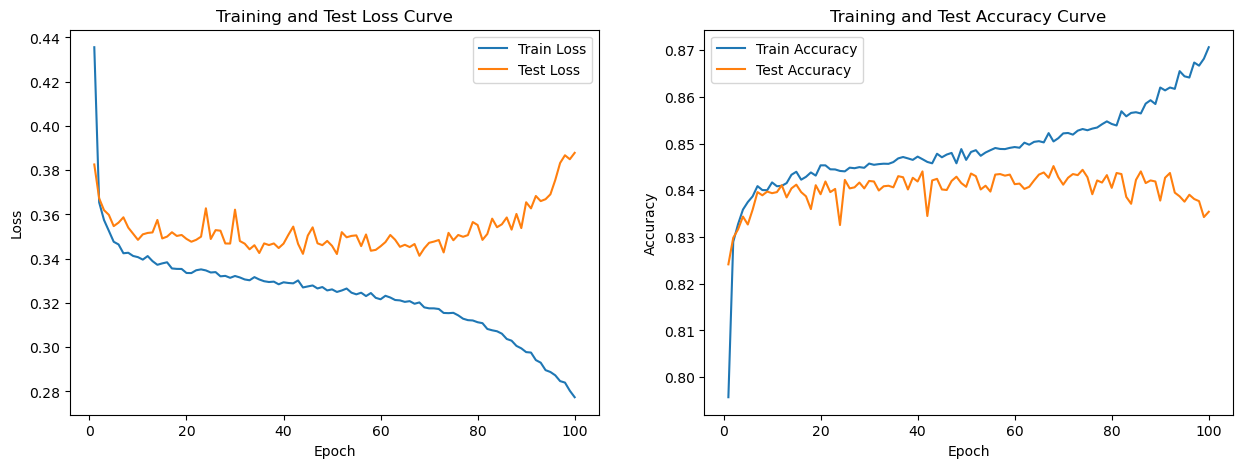

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                    
                       embedding_scheme='log-linear_periodic',
                       trainable=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Log-Linear Periodic - Linear

Epoch [ 1/100]       | Train: Loss 0.40162, Accuracy 0.81243                             | Test: Loss 0.34354, Accuracy 0.84258, F1 0.84291
Epoch [ 2/100]       | Train: Loss 0.32822, Accuracy 0.84565                             | Test: Loss 0.32620, Accuracy 0.85191, F1 0.85020
Epoch [ 3/100]       | Train: Loss 0.31753, Accuracy 0.85352                             | Test: Loss 0.31659, Accuracy 0.85635, F1 0.84999
Epoch [ 4/100]       | Train: Loss 0.31247, Accuracy 0.85501                             | Test: Loss 0.32182, Accuracy 0.85100, F1 0.85166
Epoch [ 5/100]       | Train: Loss 0.31016, Accuracy 0.85504                             | Test: Loss 0.31186, Accuracy 0.85532, F1 0.84603
Epoch [ 6/100]       | Train: Loss 0.30625, Accuracy 0.85835                             | Test: Loss 0.31099, Accuracy 0.85692, F1 0.85027
Epoch [ 7/100]       | Train: Loss 0.30503, Accuracy 0.85729                             | Test: Loss 0.31679, Accuracy 0.85259, F1 0.85216
Epoch [ 8/100]      

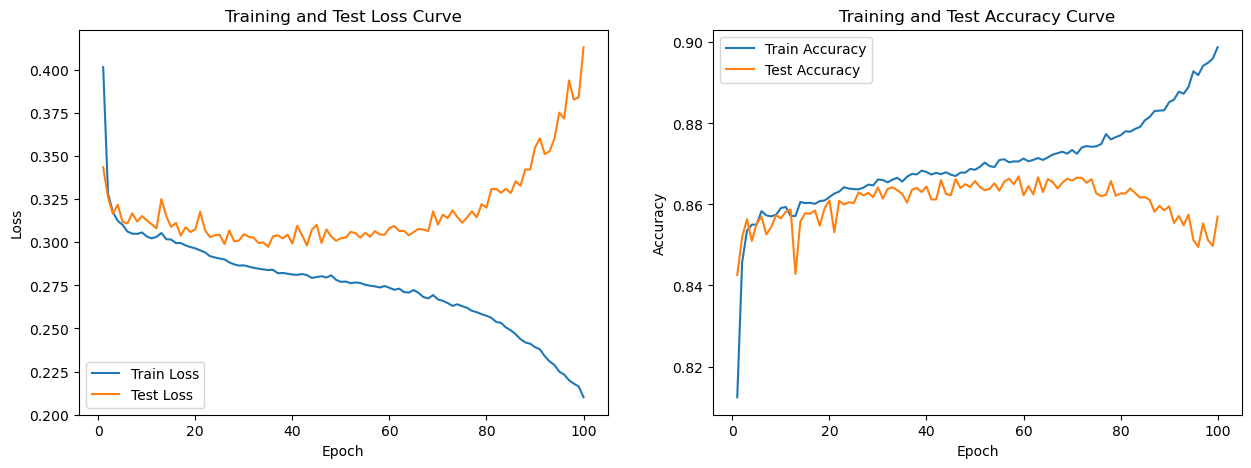

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                  
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                     
                       embedding_scheme='log-linear_periodic',
                       trainable=True,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Log-Linear Periodic. No Linear

Epoch [ 1/100]       | Train: Loss 0.44606, Accuracy 0.79022                             | Test: Loss 0.37899, Accuracy 0.81824, F1 0.81691
Epoch [ 2/100]       | Train: Loss 0.36400, Accuracy 0.82763                             | Test: Loss 0.36439, Accuracy 0.83110, F1 0.81610
Epoch [ 3/100]       | Train: Loss 0.35548, Accuracy 0.83515                             | Test: Loss 0.36045, Accuracy 0.83360, F1 0.82423
Epoch [ 4/100]       | Train: Loss 0.35102, Accuracy 0.83606                             | Test: Loss 0.35744, Accuracy 0.83417, F1 0.82252
Epoch [ 5/100]       | Train: Loss 0.34956, Accuracy 0.83638                             | Test: Loss 0.35954, Accuracy 0.83701, F1 0.83176
Epoch [ 6/100]       | Train: Loss 0.34794, Accuracy 0.83729                             | Test: Loss 0.35928, Accuracy 0.83576, F1 0.83341
Epoch [ 7/100]       | Train: Loss 0.34529, Accuracy 0.83992                             | Test: Loss 0.35185, Accuracy 0.83826, F1 0.83350
Epoch [ 8/100]      

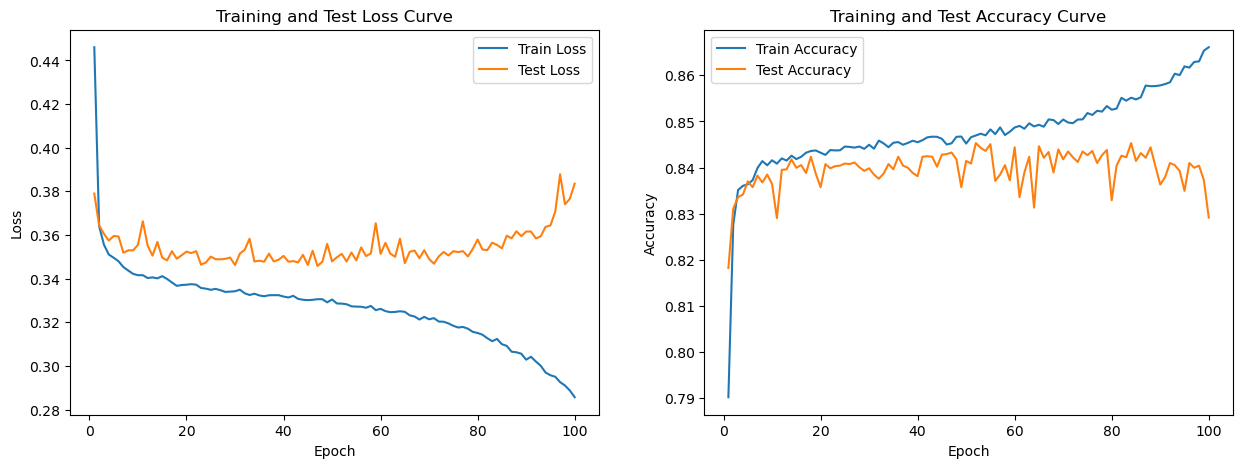

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                  
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Log-Linear Periodic - Linear

Epoch [ 1/100]       | Train: Loss 0.41732, Accuracy 0.80579                             | Test: Loss 0.34809, Accuracy 0.84304, F1 0.82771
Epoch [ 2/100]       | Train: Loss 0.33057, Accuracy 0.84580                             | Test: Loss 0.32553, Accuracy 0.85237, F1 0.85007
Epoch [ 3/100]       | Train: Loss 0.31750, Accuracy 0.85247                             | Test: Loss 0.31902, Accuracy 0.85157, F1 0.84049
Epoch [ 4/100]       | Train: Loss 0.31025, Accuracy 0.85694                             | Test: Loss 0.31689, Accuracy 0.85487, F1 0.84536
Epoch [ 5/100]       | Train: Loss 0.30905, Accuracy 0.85583                             | Test: Loss 0.31222, Accuracy 0.85612, F1 0.84763
Epoch [ 6/100]       | Train: Loss 0.30659, Accuracy 0.85779                             | Test: Loss 0.31326, Accuracy 0.85612, F1 0.84998
Epoch [ 7/100]       | Train: Loss 0.30678, Accuracy 0.85811                             | Test: Loss 0.31993, Accuracy 0.85100, F1 0.83672
Epoch [ 8/100]      

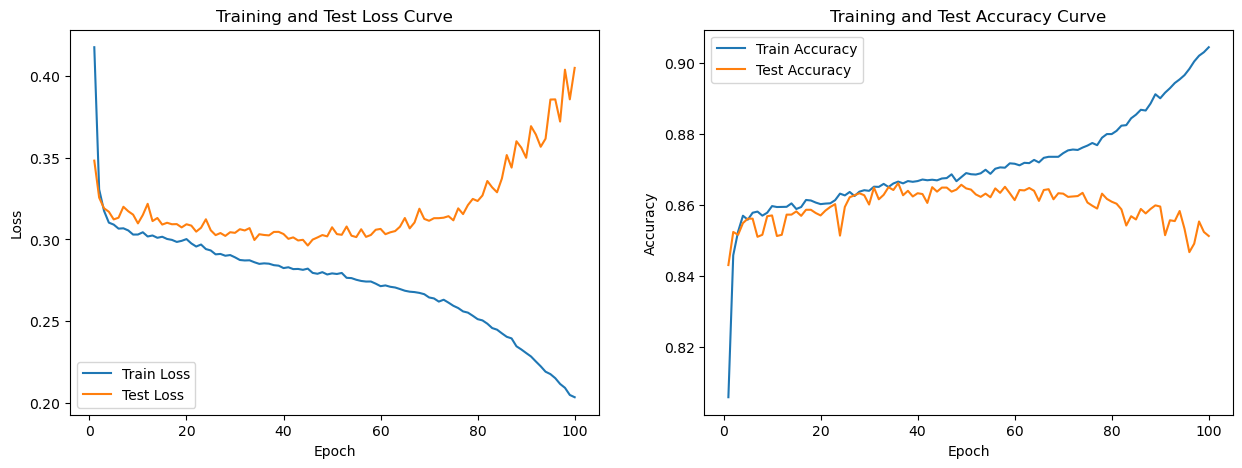

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")